# Projet 7: Advanced topics on gradient descent

# Prémiminaires

Nous importons les packages utiles

In [1]:
from math import *
import random
import numpy as np
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

import pandas as pd  #pandas pour la gestion des données 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

J'ai décidé de travailler sur un dataset que j'ai généré aléatoirement composé de 6 variables décorrélées. 
Connaissant les coefficients de régression, il est aussi plus simple de s'assurer du bon fonctionnement de la méthode et de l'implémentation de l'algorithme de descente de gradient.

In [2]:
random.seed(1)
n=1000
nbr_var=6
x=np.zeros((n,nbr_var))
sd=10
mu=50
for i in range(nbr_var):
  x[:,i]= np.random.randn(n)*sd+mu
design=pd.DataFrame(x,columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
coef=np.array([6,4,0.8,0.02,7,3.8]).reshape(-1,1)
y=np.dot(design,coef)+np.random.randn(n).reshape(-1,1)

In [16]:
#Séparation du training set et du test set
X_train,X_test,y_train,y_test=train_test_split(design,y,test_size=0.33, random_state=1)


Nous déterminons la borne supérieure pour le pas de la descent de gradient

In [4]:
#Plus grand valeur propre de la matrice de XX.T
max_ev=max(np.linalg.eigvals(np.dot(X_train, X_train.T))).real
# Nous obtenons la borne supérieur du pas que nous pouvons utilisant grace au résulat théorique suivant 
step=1/max_ev
step

9.910175586612398e-08

In [5]:
# Définition de la fonction de perte
def ridge_error(y,X,beta,lambd):

  return(((np.dot(X,beta)-y)**2).sum()/2+lambd*(beta**2).sum()/2)/len(y)

In [231]:
def gradient_descent_ridge(X, y,lambd, learningrate=1e-3, epochs=10000,epsilon=1e-2,monit=True,arret=True):
    """
  Algorithme de descent de gradient avec pénalité ridge
  
  Parametres
  ----------
  X : np.array
    matrice de design

  y : np.array
    vecteur du target

  lambd: float
    parametre de régularisation

  epochs: int
    Nombre d'epochs


  monit : bool
      Affiche l'itération en cours


  
  arret : bool
      Algorithme s'arrete lorsque la condition d'arret est satisfaite
  
  std : float, default=1.
      Standard-deviation of the noise

  epsilon : float
      Paramètre de précision pour la condition d'arret
  """  
    ridge=[]
    beta = pd.DataFrame([0,0,0,0,0,0]) # Initialisation des coefficients
    for i in range(epochs+1):
      if i%(epochs/100)==0 and monit: #monitoring
        print("itération {} en cours ...".format(i))
      # Updating beta
      delta =  np.subtract(np.dot(X,beta),y.reshape(-1,1))
      gradient=np.dot(X.T,delta)+ lambd*beta
      beta_new= beta-learningrate * gradient # on retire un gradient
      ridge.append(ridge_error(y,X,beta_new,lambd)) # on calcule l'erreur
      
      if np.linalg.norm(gradient)<epsilon and arret: #condition d'arrêt
        print("L'algorithme a convergé ")
        break
      beta=beta_new
     
    return beta,ridge

## Question 1 : Implémentation de heavy ball

In [39]:
def ridge_gradient(X, y, lambd, beta):
  delta = np.subtract(np.dot(X,beta),y.reshape(-1,1))
  return np.dot(X.T,delta)+ lambd*beta 

def gradient_heavy_ball(X, y,lambd,momentum, learningrate=1e-3, epochs=10000,epsilon=1e-2,monit=True,arret=True):
  """
  Algorithme de descent de gradient avec pénalité ridge
  
  Parametres
  ----------
  X : np.array
    matrice de design

  y : np.array
    vecteur du target

  lambd: float
    parametre de régularisation

  epochs: int
    Nombre d'epochs


  monit : bool
      Affiche l'itération en cours


  
  arret : bool
      Algorithme s'arrete lorsque la condition d'arret est satisfaite
  
  std : float, default=1.
      Standard-deviation of the noise

  epsilon : float
      Paramètre de précision pour la condition d'arret
  """  
  X=np.array(X)
  y=np.array(y)
  ridge=[]
  beta = np.array([0,0,0,0,0,0]).reshape(-1,1) # Initialisation des coefficients
  g=ridge_gradient(X, y, lambd, beta)
  for i in range(epochs+1):
    if i%(epochs/100)==0 and monit: #monitoring
      print("itération {} en cours ...".format(i))
    # Updating beta
    g_new =  ridge_gradient(X, y, lambd, beta)
    direction_descente= momentum*g + (1- momentum)*g_new
    beta_new= beta-learningrate * direction_descente # on retire un gradient
    ridge.append(ridge_error(y,X,beta_new,lambd)) # on calcule l'erreur
    
    if np.linalg.norm(g)<epsilon and arret: #condition d'arrêt
      print("L'algorithme a convergé ")
      break
    beta=beta_new
    g=g_new
  return beta,ridge

In [54]:
beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=0.2, learningrate=step, epochs=10000,epsilon=1e-2,monit=False,arret=True)

L'algorithme a convergé 


Prédiction de Heavy ball:

In [41]:

beta_HB


array([[6.00080187],
       [3.99751216],
       [0.80064892],
       [0.01677535],
       [6.99942633],
       [3.80570351]])

In [230]:
print('Solution réelle')
coef

Solution réelle


array([[6.  ],
       [4.  ],
       [0.8 ],
       [0.02],
       [7.  ],
       [3.8 ]])

La prédiction de l'algorithme de heavy ball est proche de la vraie solution.

Nous allons optimiser à la fois le paramètre momentum du heavy ball et le stepsize. Pour cela nous allons comparer, pour toutes les configurations possibles, la vitesse de convergence.

Dans un premier temps, nous allons choisir le momentum dans $]0,0.5[$ et un stepsize dans (0.1*step , 2*step), avec step l'inverse de la plus grande valeur propre.

<function matplotlib.pyplot.show(*args, **kw)>

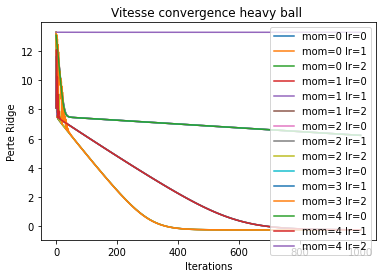

In [139]:
mom=np.linspace(0.1,0.5,5)
stpsize=np.linspace(0.1*step,2*step,3)


plt.figure()
for i in range(len(mom)):
  for k in range(len(stpsize)):
    beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=mom[i], learningrate=stpsize[k], epochs=1000,epsilon=1e-2,monit=False,arret=False)
    plt.plot(np.log(loss_HB),label='mom='+str(i)+' lr='+str(k))
plt.title('Convergence HB pour different momentum et stepsize')
plt.xlabel('Iterations')
plt.title('Vitesse convergence heavy ball ')
plt.legend(loc = "upper right")
plt.ylabel('Perte Ridge')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

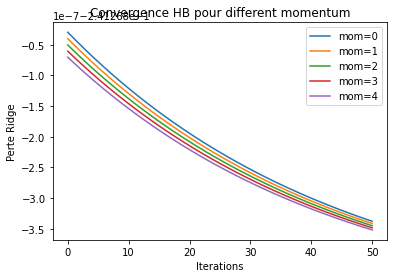

In [140]:
mom=np.linspace(0.01,0.4,5)
plt.figure()
for i in range(len(mom)):
  beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=mom[i], learningrate=2*step, epochs=1000,epsilon=1e-2,monit=False,arret=False)
  plt.plot(np.log(loss_HB)[950:],label='mom='+str(i))
plt.title('Convergence HB pour different momentum')
plt.xlabel('Iterations')
plt.legend(loc = "upper right")
plt.ylabel('Perte Ridge')
plt.legend()
plt.show

On peut remarquer sur le graphique ci-dessus que dans le cas où  0$ <$  momentum $<$ 0.5 :
- pour un même step size mais des momentums différents, les courbes des vitesses de convergence sont quasi confondues. 

- le pas otimal est celui qui est le plus proche de 2*step, tout en restant strictement inférieur à ce dernier. 

- en tracant la vitesse de convergence pour chaque momentum, on remarque que le momentum optimal est celui qui est le plus proche de 0.5.

Nous répétons l'expérience pour 0.5$ <$  momentum $<$ 1

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


<function matplotlib.pyplot.show(*args, **kw)>

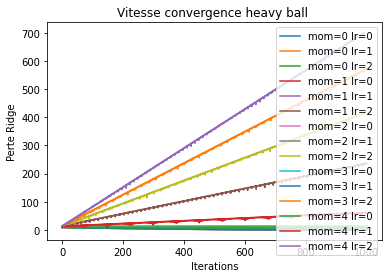

In [117]:
mom=np.linspace(0.5,1,5)
stpsize=np.linspace(0.1*step,2*step,3)


plt.figure()
for i in range(len(mom)):
  for k in range(len(stpsize)):
    beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=mom[i], learningrate=stpsize[k], epochs=1000,epsilon=1e-2,monit=False,arret=False)
    plt.plot(np.log(loss_HB),label='mom='+str(i)+' lr='+str(k))
plt.xlabel('Iterations')
plt.title('Vitesse convergence heavy ball ')
plt.legend(loc = "upper right")
plt.ylabel('Perte Ridge')
plt.legend()
plt.show

On peut remarquer sur le graphique ci-dessus que dans le cas où  0.5$ <$  momentum $<$ 1 :
- pour un même step size mais des momentums différents les courbes des vitesses de convergence sont quasi confondues. 

- l'algorithme a tendance à diverger, il faut donc choisir un stepsize plus petit 



<function matplotlib.pyplot.show(*args, **kw)>

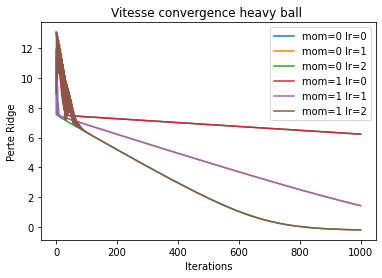

In [125]:
mom=np.linspace(0.5,1,2)
stpsize=np.linspace(0.1*step,0.9*step,3)


plt.figure()
for i in range(len(mom)):
  for k in range(len(stpsize)):
    beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=mom[i], learningrate=stpsize[k], epochs=1000,epsilon=1e-2,monit=False,arret=False)
    plt.plot(np.log(loss_HB),label='mom='+str(i)+' lr='+str(k))
plt.xlabel('Iterations')
plt.title('Vitesse convergence heavy ball ')
plt.legend(loc = "upper right")
plt.ylabel('Perte Ridge')
plt.legend()
plt.show

On peut constater qu'à partir d'un stepsize de  0.9, l'algorithme diverge, mais le stepsize optimal est celui qui se rapproche le plus de cette valeur. 
On peut maintenat optimiser le momentum.

<function matplotlib.pyplot.show(*args, **kw)>

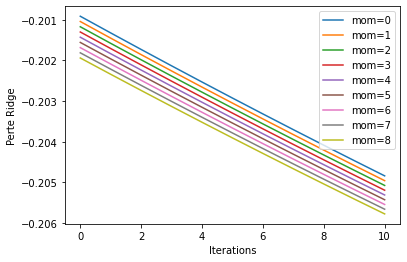

In [128]:
mom=np.linspace(0.5,0.98,9)
plt.figure()
for i in range(len(mom)):
  beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=mom[i], learningrate=0.9*step, epochs=1000,epsilon=1e-2,monit=False,arret=False)
  plt.plot(np.log(loss_HB)[990:],label='mom='+str(i))
plt.xlabel('Iterations')
plt.legend(loc = "upper right")
plt.ylabel('Perte Ridge')
plt.legend()
plt.show

Le momentum optimal est celui qui se rapproche le plus de 1.

Finalement comparons les deux optima que nous avons identifiés:
- Opti 1: momentum=0.4 et pas=1.99*step
- Opti 2: momentum=0.9 et pas=0.99*step


<function matplotlib.pyplot.show(*args, **kw)>

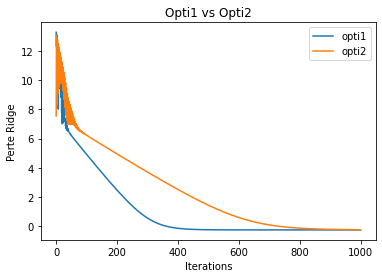

In [141]:
beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=0.4, learningrate=1.99*step, epochs=1000,epsilon=1e-2,monit=False,arret=False)
plt.plot(np.log(loss_HB),label='opti1')
beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=0.9, learningrate=0.99*step, epochs=1000,epsilon=1e-2,monit=False,arret=False)
plt.plot(np.log(loss_HB),label='opti2')
plt.title('Opti1 vs Opti2')
plt.xlabel('Iterations')
plt.legend(loc = "upper right")
plt.ylabel('Perte Ridge')
plt.legend()
plt.show

Le meilleur paramétrage est celui de Opti 1:
- momentum=0.4 
- pas=1.99*step

## Question 2:

Maintenant comparons l'algorithme de heavy ball avec le paramètrage optimal avec la descente de gradient classique.

<function matplotlib.pyplot.show(*args, **kw)>

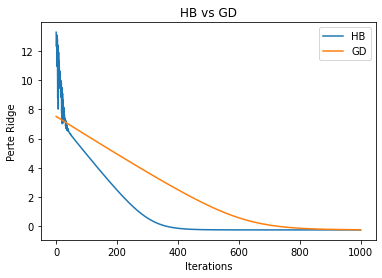

In [144]:
beta_HB, loss_HB=gradient_heavy_ball(X_train, y_train,lambd=3,momentum=0.4, learningrate=1.99*step, epochs=1000,epsilon=1e-2,monit=False,arret=False)
plt.plot(np.log(loss_HB),label='HB')
beta_GD, loss_GD=gradient_descent_ridge(X_train, y_train,lambd=3, learningrate= step, epochs=1000,epsilon=1e-2,monit=False,arret=False)
plt.plot(np.log(loss_GD),label='GD')
plt.title('HB vs GD')
plt.xlabel('Iterations')
plt.legend(loc = "upper right")
plt.ylabel('Perte Ridge')
plt.legend()
plt.show

Heavy Ball converge plus vite que l'algorithme de descente de gradient classique.

## Question 3: 

Dans cette partie nous allons utiliser la fonction de perte suivante:


$$ ||X \beta-Y||^2 + \lambda ||\beta||^2 + (\sum_{i = 1}^{d} |\beta_i|^q)^{\frac{1}{q}}$$
dont le gradient est :
$$ 2 [X^T(X \beta - Y) + \lambda \beta] +\left[ sgn(\beta_j) \times (\frac{|\beta_j|}{||\beta||_q})^{q - 1}\right]_{1\leq j\leq d}$$

Avec $0<q<1$.

In [225]:
def qnorm(beta) :
    return(np.sum(np.abs(beta**q))**(1/q))


def ridge_gradient(X, Y, lambd, beta):
    delta = np.dot(X,beta) - Y
    N=len(X)
    return (2/N) * np.dot(X.T, delta) + 2*lambd*beta #scaling the gradient to increase performance

def loss_nc(X, Y, lambd, beta) :
    a = np.dot(X, beta) - Y
    b = np.linalg.norm(a)
    c = np.square(b)
    d = np.linalg.norm(beta)
    return (1/X.shape[0]) * c + lambd * np.square(d) + qnorm(beta)

def qnorm_gradient(X, Y, lambd, beta):
    grad = np.abs(beta)/qnorm(beta)
    grad = 1/(grad**(1-q))
    grad = np.sign(beta)*grad
    return grad
def loss_nc_gradient(X, Y, lambd, beta) :
  return ridge_gradient(X, Y, lambd, beta) + qnorm_gradient(X, Y, lambd, beta)

def gradient_NC(X, y,lambd, learningrate=1e-3, epochs=10000,epsilon=1e-2,monit=True,arret=True):
  X=np.array(X)
  y=np.array(y)
  loss=[]
  beta = np.array([1,1,1,1,1,1]).reshape(-1,1) # Initialisation des coefficients
  
  for i in range(epochs+1):
    if i%(epochs/100)==0 and monit: #monitoring
      print("itération {} en cours ...".format(i))
    # Updating beta
    
    gradient= loss_nc_gradient(X, y, lambd, beta)
    
    beta_new= beta-learningrate * gradient # on retire un gradient
    loss.append(loss_nc(X,y,lambd,beta_new)) # on calcule l'erreur
    
    if np.linalg.norm(gradient)<epsilon and arret: #condition d'arrêt
      print("L'algorithme a convergé ")
      break
    beta=beta_new
   
  return beta,loss

On rappelle le pas optimal:

In [226]:

step

9.910175586612398e-08

In [227]:
q=0.5
beta_nc,loss_nc=gradient_NC(X_train, y_train,lambd=2, learningrate=2*step, epochs=100000,epsilon=1e-2,monit=False,arret=True)

In [228]:
beta_nc

array([[5.92297097],
       [4.03448854],
       [0.9000998 ],
       [0.11043268],
       [6.88671934],
       [3.76104959]])

Text(0.5, 1.0, 'Vitesse de convergence descent de gradient: non conex vers convex')

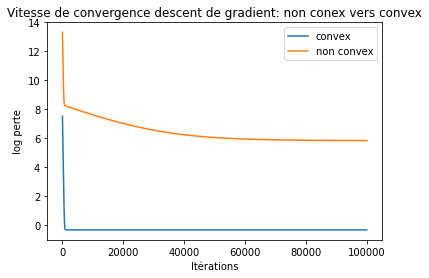

In [232]:
beta_GD, loss_GD=gradient_descent_ridge(X_train, y_train,lambd=2, learningrate= step, epochs=100000,epsilon=1e-2,monit=False,arret=False)
plt.plot(np.log(loss_GD),label='convex')
plt.plot(np.log(loss_nc),label='non convex')
plt.xlabel('Itérations')
plt.ylabel('log perte')
plt.legend()
plt.title('Vitesse de convergence descent de gradient loss conex ')

L'algorithme de la descente de gradient avec une fonction de perte non convexe converge et les coeficients prédits sont assez proches des coefficients réels. Cependant la vitesse de convergence est très lente comparée au cas convex.
( on ne peut pas comparer leur fonction de perte sur le graphique car elles sont différentes).